In [4]:
import openai

import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import csv
import os

from scipy.stats import ttest_rel, ttest_ind
import numpy as np

from judgement_utils import list_files

In [163]:
def score_helper(df, groupby):
    """
    The input is a DataFrame containing the data to process. These are the results 
    of the benchmarking test cases extracted from a csv file. 
    From that data the scores are extracted and the results are aggregated per 
    Iteration and per model. It returns the raw results, as well as the aggregated 
    scores and the aggregated scores per iteration.
    """
    raw_results = df.copy()
    raw_results["score_possible"] = raw_results["rating"].apply(
        lambda x: float(x.split("/")[1])
    )
    raw_results["scores"] = raw_results["rating"].apply(
        lambda x: x.split("/")[0]
    )
    raw_results["score_achieved_total"] = raw_results["scores"].apply(
        lambda x: np.sum([float(score) for score in x.split(";")])
    )
    raw_results["iteration_scores"] = raw_results["scores"].apply(
        lambda x: [float(score) for score in x.split(";")]
    )
    raw_results["iteration_index"] = raw_results["iteration_scores"].apply(
        lambda x: list(range(1, len(x) + 1))
    )

    # Explode the iteration scores and iteration index to have a row for each iteration
    exploded_results = raw_results.explode(["iteration_scores", "iteration_index"])
    exploded_results["iteration_scores"] = exploded_results["iteration_scores"].astype(float)
    exploded_results["iteration_index"] = exploded_results["iteration_index"].astype(int)
    
    if groupby == "subtask":
        # Set 'evaluated_model' to 'subtask' to filter for the prompt subtasks
        aggregated_results_iteration = exploded_results.groupby([f"{groupby}", "iteration_index"]).agg(
            metric = ("metric" , "first"),
            ev_model=("evaluated_model", "first"),
            score_possible=("score_possible", "sum"),
            score_achieved_total=("iteration_scores", "sum"),
        ).reset_index()

        aggregated_results_iteration["score_achieved_mean"] = aggregated_results_iteration["score_achieved_total"] / aggregated_results_iteration["score_possible"]

        # Set 'evaluated_model' to 'subtask' to filter for the prompt subtasks 
        aggregated_scores = raw_results.groupby([f"{groupby}"]).agg(
            metric = ("metric" , "first"),
            ev_model=("evaluated_model", "first"),
            score_possible=("score_possible", "sum"),
            score_achieved_total=("score_achieved_total", "sum"),
            iterations=("iterations", "first")
        ).reset_index()
    else:
        # Set 'evaluated_model' to 'subtask' to filter for the prompt subtasks
        aggregated_results_iteration = exploded_results.groupby([f"{groupby}", "iteration_index"]).agg(
            metric = ("metric" , "first"),
            score_possible=("score_possible", "sum"),
            score_achieved_total=("iteration_scores", "sum"),
        ).reset_index()

        aggregated_results_iteration["score_achieved_mean"] = aggregated_results_iteration["score_achieved_total"] / aggregated_results_iteration["score_possible"]

        # Set 'evaluated_model' to 'subtask' to filter for the prompt subtasks 
        aggregated_scores = raw_results.groupby([f"{groupby}"]).agg(
            metric = ("metric" , "first"),
            ev_model=("evaluated_model", "first"),
            score_possible=("score_possible", "sum"),
            score_achieved_total=("score_achieved_total", "sum"),
            iterations=("iterations", "first")
        ).reset_index()

    aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * raw_results.iloc[:, 2][0]
    aggregated_scores['score_achieved_avg'] = aggregated_scores['score_achieved_total'] / raw_results.iloc[:, 2][0]
    aggregated_scores['score_achieved_mean'] = aggregated_scores['score_achieved_total'] / aggregated_scores['score_possible_total'][0]

    # Set 'evaluated_model' to 'subtask' to calculate 'std_results' for prompt subtasks
    std_results = aggregated_results_iteration.groupby([f"{groupby}"])["score_achieved_mean"].std().reset_index()
    aggregated_scores['score_achieved_std'] = std_results.iloc[:, 1]

    return raw_results, exploded_results, aggregated_scores, aggregated_results_iteration

In [140]:
agg = score_helper(pd.read_csv("./model_eval/gpt-4o-mini-2024-07-18_correctness.csv"), groupby = "evaluated_model")
agg[2]

,evaluated_model,metric,ev_model,score_possible,score_achieved_total,iterations,score_possible_total,score_achieved_avg,score_achieved_mean,score_achieved_std
0,gpt-4o-mini-2024-07-18,correctness,gpt-4o-mini-2024-07-18,257.0,382.0,2,514.0,191.0,0.743191,0.0


In [161]:
def create_frames(dir_name: str, groupby: str, index):
    dfs = []
    for file in sorted(list_files(path = f"./{dir_name}/")):
        _ = []
        data = pd.read_csv(f"./{dir_name}/{file}")
        agg = score_helper(df = data, groupby = groupby)
        _.append(agg[index])
        dfs.append(_)
    return dfs

In [162]:
df = create_frames(dir_name = "model_eval", groupby = "case_id", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)
df

,case_id,metric,ev_model,score_possible,score_achieved_total,iterations,score_possible_total,score_achieved_avg,score_achieved_mean,score_achieved_std
0,1,correctness,gpt-4o-mini-2024-07-18,18.0,36.0,2,36.0,18.0,2.000000,0.0
1,2,correctness,gpt-4o-mini-2024-07-18,9.0,18.0,2,18.0,9.0,1.000000,0.0
2,5,correctness,gpt-4o-mini-2024-07-18,20.0,0.0,2,40.0,0.0,0.000000,0.0
3,6,correctness,gpt-4o-mini-2024-07-18,24.0,36.0,2,48.0,18.0,2.000000,0.0
4,7,correctness,gpt-4o-mini-2024-07-18,24.0,48.0,2,48.0,24.0,2.666667,0.0
5,8,correctness,gpt-4o-mini-2024-07-18,24.0,30.0,2,48.0,15.0,1.666667,0.0
6,9,correctness,gpt-4o-mini-2024-07-18,24.0,0.0,2,48.0,0.0,0.000000,0.0
7,10,correctness,gpt-4o-mini-2024-07-18,24.0,48.0,2,48.0,24.0,2.666667,0.0
8,11,correctness,gpt-4o-mini-2024-07-18,24.0,34.0,2,48.0,17.0,1.888889,0.0
9,12,correctness,gpt-4o-mini-2024-07-18,24.0,48.0,2,48.0,24.0,2.666667,0.0


In [148]:
colours = {
    "comprehensiveness": "#b3cde0",
    "correctness": "#005b96",
    "usefulness": "#03396c",
    "simple": "#e58996",
    "detailed": "#db6480",
    "explicit": "#701f62",
    "geriatric": "#317873",
    "mid-aged/pregeriatric": "#5f9ea0",
    "young": "#a0d6b4",
}

Bar 1: Height = 0.7432, Std = 0.0000


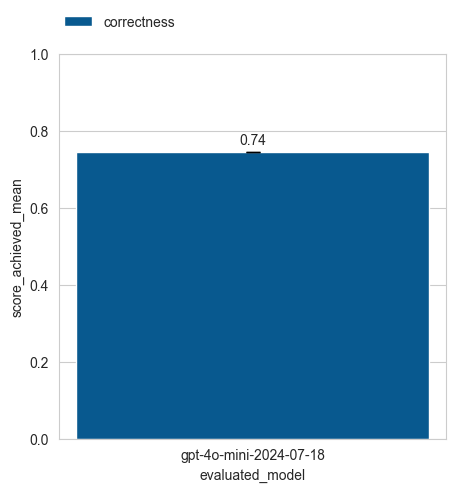

In [144]:
df = create_frames(dir_name = "model_eval", groupby = "evaluated_model", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)

sns.set_style(style = "whitegrid")

grouped = df.groupby(["evaluated_model", "metric"]).agg(
    score_achieved_mean=("score_achieved_mean", "mean"),
    score_achieved_std=("score_achieved_std", "mean")  # Preserve std as mean (or pick another function)
).reset_index()

plt.figure(figsize = (5, 5))
plot = sns.barplot(x = "evaluated_model", 
                   y = "score_achieved_mean", 
                   hue = "metric", 
                   data = grouped,
                   errorbar = ("sd"),
                   palette = colours, 
                   saturation = 0.9)

std_values = grouped["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)
plt.legend(bbox_to_anchor = (0, 1.05),
           loc = "lower left",
           ncols = 2,
           frameon = False,
           borderaxespad = 0.)
plt.ylim(0, 1.0)
plt.show()

Bar 1: Height = 0.7326, Std = 0.0000
Bar 2: Height = 0.7558, Std = 0.0000
Bar 3: Height = 0.7326, Std = 0.0000


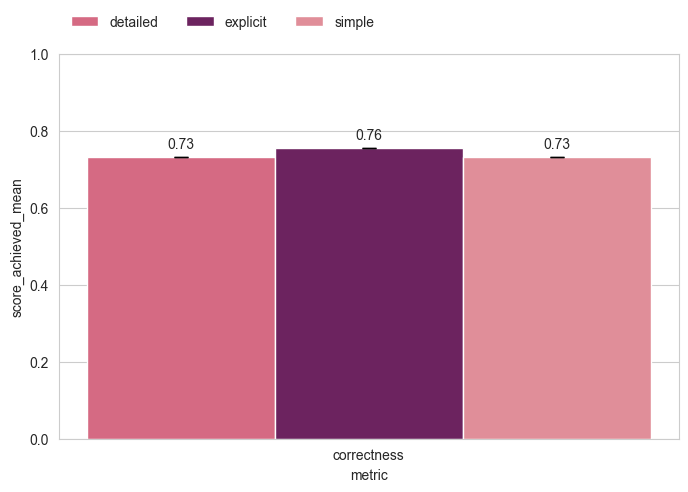

In [149]:
df = create_frames(dir_name = "model_eval", groupby = "system_prompt", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)

sns.set_style(style = "whitegrid")

grouped = df.groupby(["system_prompt", "metric"]).agg(
    score_achieved_mean=("score_achieved_mean", "mean"),
    score_achieved_std=("score_achieved_std", "mean")  # Preserve std as mean (or pick another function)
).reset_index()

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "metric", 
                   y = "score_achieved_mean", 
                   hue = "system_prompt", 
                   data = grouped,
                   errorbar = ("sd"),
                   palette = colours, 
                   saturation = 0.9)

std_values = grouped["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)

plt.legend(bbox_to_anchor = (0.01, 1.05),
           loc = "lower left",
           ncols = 3,
           frameon = False,
           borderaxespad = 0.)
plt.ylim(0, 1)
plt.show()

Bar 1: Height = 0.8939, Std = 0.0000
Bar 2: Height = 0.9091, Std = 0.0000
Bar 3: Height = 1.0909, Std = 0.0000


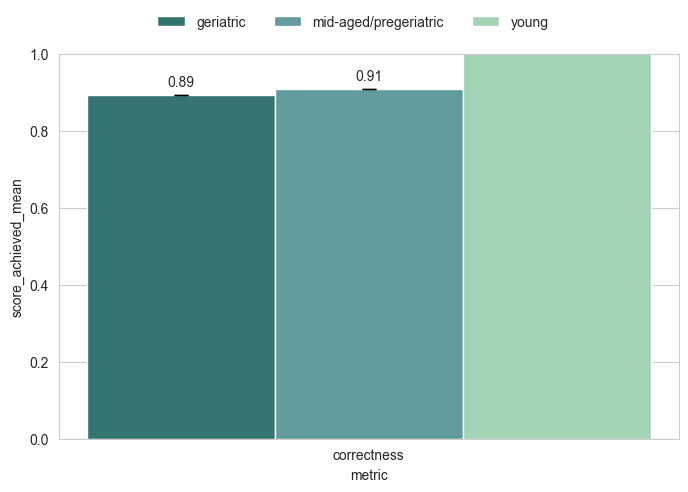

In [152]:
df = create_frames(dir_name = "model_eval", groupby = "individual", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)

sns.set_style(style = "whitegrid")

grouped = df.groupby(["individual", "metric"]).agg(
    score_achieved_mean=("score_achieved_mean", "mean"),
    score_achieved_std=("score_achieved_std", "mean")  # Preserve std as mean (or pick another function)
).reset_index()

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "metric", 
                   y = "score_achieved_mean", 
                   hue = "individual", 
                   data = grouped,
                   errorbar = ("sd"),
                   palette = colours, 
                   saturation = 0.9)

std_values = grouped["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)

plt.legend(bbox_to_anchor = (0.15, 1.05),
           loc = "lower left",
           ncols = 3,
           frameon = False,
           borderaxespad = 0.)
plt.ylim(0, 1)
plt.show()

Bar 1: Height = 0.7364, Std = 0.0000
Bar 2: Height = 0.7442, Std = 0.0000


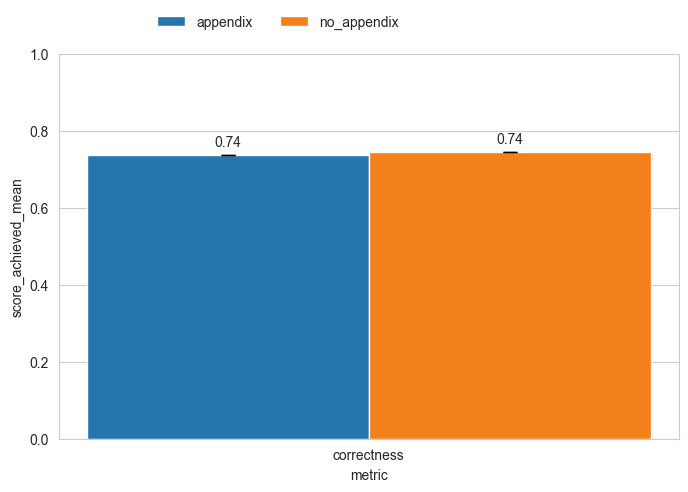

In [153]:
df = create_frames(dir_name = "model_eval", groupby = "is_appendix", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)

sns.set_style(style = "whitegrid")

grouped = df.groupby(["is_appendix", "metric"]).agg(
    score_achieved_mean=("score_achieved_mean", "mean"),
    score_achieved_std=("score_achieved_std", "mean")  # Preserve std as mean (or pick another function)
).reset_index()

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "metric", 
                   y = "score_achieved_mean", 
                   hue = "is_appendix", 
                   data = grouped,
                   errorbar = ("sd"),
                #    palette = colours, 
                   saturation = 0.9)

std_values = grouped["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)

plt.legend(bbox_to_anchor = (0.15, 1.05),
           loc = "lower left",
           ncols = 3,
           frameon = False,
           borderaxespad = 0.)
plt.ylim(0, 1)
plt.show()

Bar 1: Height = 0.7520, Std = 0.0000
Bar 2: Height = 0.7760, Std = 0.0000


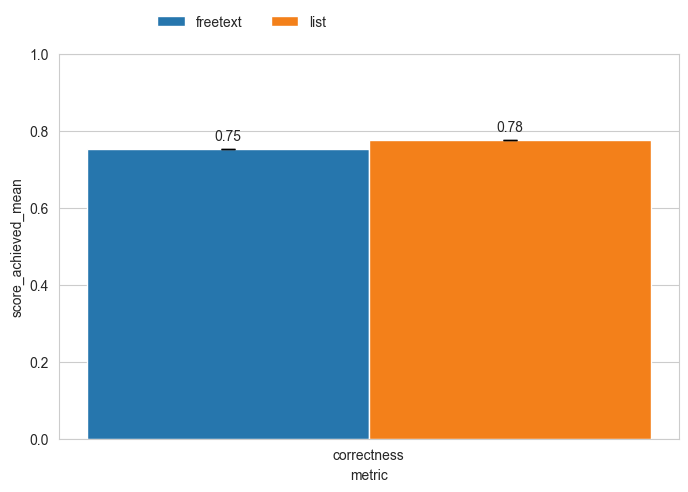

In [154]:
df = create_frames(dir_name = "model_eval", groupby = "prompt_type", index = 2)
df = pd.concat(df[0][0:len(df[0])], ignore_index = True)

sns.set_style(style = "whitegrid")

grouped = df.groupby(["prompt_type", "metric"]).agg(
    score_achieved_mean=("score_achieved_mean", "mean"),
    score_achieved_std=("score_achieved_std", "mean")  # Preserve std as mean (or pick another function)
).reset_index()

plt.figure(figsize = (8, 5))
plot = sns.barplot(x = "metric", 
                   y = "score_achieved_mean", 
                   hue = "prompt_type", 
                   data = grouped,
                   errorbar = ("sd"),
                #    palette = colours, 
                   saturation = 0.9)

std_values = grouped["score_achieved_std"].to_numpy()
for i, patch in enumerate(plot.patches[:len(std_values)]):
    std = std_values[i]
    extra = 0
    height = patch.get_height()
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
    if patch.get_height() > 0:
        plt.errorbar(x=patch.get_x() + patch.get_width() / 2,
                     y=patch.get_height(),
                     yerr=std,
                     fmt='none',
                     c='black',
                     capsize=5)
        plt.annotate(format(patch.get_height(), ".2f"),
                      (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                      ha = "center",
                      va = "center",
                      xytext = (0, 9),
                      textcoords = "offset points",
                      fontsize = 10)

plt.legend(bbox_to_anchor = (0.15, 1.05),
           loc = "lower left",
           ncols = 3,
           frameon = False,
           borderaxespad = 0.)
plt.ylim(0, 1)
plt.show()